# County level analysis: Figure 2

### Packages & Function definitions

In [126]:
import numpy as np
import pandas as pd
import geopandas as gp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['mathtext.rm'] = 'Avenir'
plt.rcParams['mathtext.it'] = 'Avenir:italic'
plt.rcParams['mathtext.bf'] = 'Avenir:bold'
plt.rcParams['font.size'] = 18
plt.rcParams['pdf.fonttype'] = 42

cm_data = np.loadtxt("../../other/plotting_tools/turku.txt")[::-1]
turku_map = LinearSegmentedColormap.from_list('turku', cm_data)

cm_data = np.loadtxt("../../other/plotting_tools/vik.txt")[::-1]
vik_map = LinearSegmentedColormap.from_list('vik', cm_data)

In [2]:
# Import plotting shapefiles
county_shp = gp.read_file('../../other/plotting_tools/counties_contig_plot.shp')
county_shp["fips"] = county_shp["fips"].astype(str).str.zfill(5)

# Add State filter for plot
county_shp_plot = county_shp.copy()
county_shp_plot['state'] = county_shp_plot['fips'].str[:2]
county_shp_plot.set_index(['state'], inplace=True)
StateDrop = ['53', '41', '16', '06', '04', '49', '56', '30', '08', '35', '32'] # Western half of CONUS
county_shp_plot = county_shp_plot.drop(StateDrop)
county_shp_plot.set_index(['fips'], inplace=True)

states = gp.read_file('../../other/plotting_tools/states_contig_plot.shp')
coast = gp.read_file('../../other/plotting_tools/coast_contig_plot.shp')

In [3]:
def get_weather(x):
    return x['gdd']*beta_gdd + x['edd']*beta_edd + x['prcp']*beta_prcp + x['prcp2']*beta_prcp2

In [4]:
coef = pd.read_csv('../../data/yield/regression_coeffs+95.csv', index_col=0)
beta_gdd = coef.loc['gdd']['coeff']
beta_edd = coef.loc['edd']['coeff']
beta_prcp = coef.loc['prcp']['coeff']
beta_prcp2 = coef.loc['prcp2']['coeff']

In [5]:
def get_norm(lst):

    minima = min(lst)
    maxima = max(lst)

    return mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)

def get_custom_cmap(lst):

    minima = min(lst)
    maxima = max(lst)

    norm = get_norm(lst)
    mapper = cm.ScalarMappable(norm=norm, cmap=turku_map)
    
    return [mapper.to_rgba(v) for v in lst]

## Read in data

In [64]:
# Read in GMFD data
gmfd_yield = pd.read_csv('../../data/yield/GMFD/all_gmfd_historical.csv')
gmfd_yield["fips"] = gmfd_yield["fips"].astype(str).str.zfill(5)
yield_fips = gmfd_yield['fips'].unique() # Only take fips codes
#### Note that the simulated values from R only include the USDA county-years, 
#### so there would be some values missing for comparison to the models.

gmfd = pd.read_csv('../../data/climate/GMFD/agvar_historical_gmfd.csv')
gmfd = gmfd.query('year >= 1956 and year <= 2005')
gmfd['prcp2'] = gmfd['prcp']**2
gmfd['weather'] = gmfd.apply(get_weather, axis=1)
gmfd["fips"] = gmfd["fips"].astype(str).str.zfill(5)
all_fips = gmfd['fips'].unique()
gmfd.set_index(['fips', 'year'], inplace = True)

In [15]:
# Construct national weights (total production by weighted sum of counties)
weights = pd.read_csv('../../data/usda/maize_county_yield_area.csv').filter(["fips", "year", "area","yield"])
weights = weights.query('year >= 1956 and year <= 2005')
weights['fips'] = weights['fips'].astype(str).str.zfill(5)
weights.sort_values(by = ['fips', 'year'], inplace = True)
weights.set_index(['fips', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["fips","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['fips','year']).sort_index()
weights = weights.filter(['national_weight'])

In [16]:
# Average historical
weights_all = weights.groupby('fips').sum()
weights_all = weights_all.loc[yield_fips]
weights_all['national_weight'] = weights_all['national_weight']/weights_all['national_weight'].sum()

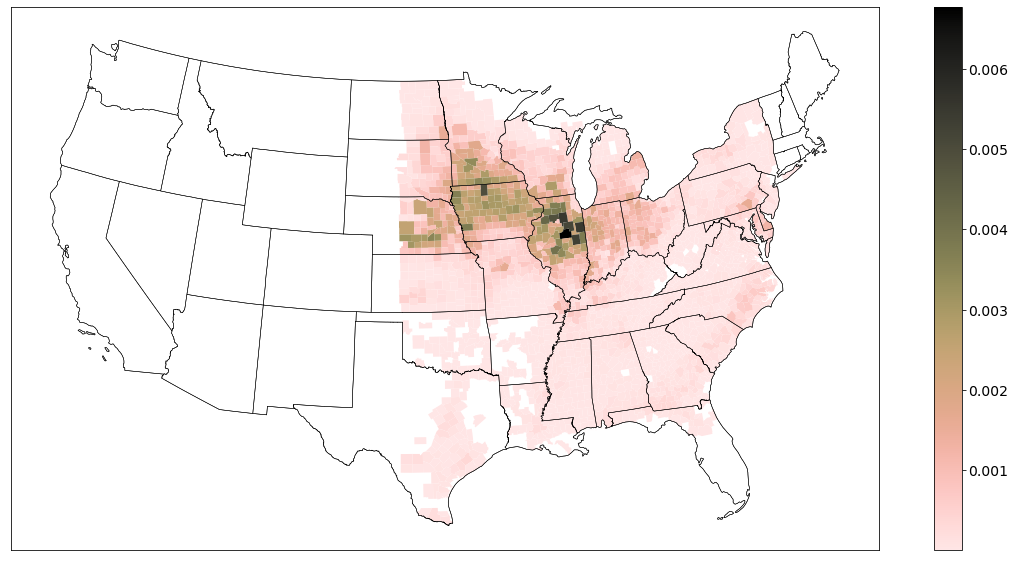

In [103]:
# Check weights
fig, ax = plt.subplots(figsize=(20,10))

# n = 1000
# top_n = weights_all['national_weight'].sort_values()[-n:].index
# weights_plot = weights_all.loc[top_n]

plotdat = pd.merge(county_shp_plot, weights_all, on='fips', how='inner')
plotdat.plot(column='national_weight', ax=ax, legend=True, cmap=turku_map)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
plt.show()

In [18]:
# Read in NEX models
nex_models = !ls ../../data/yield/NEX-GDDP/hist
nex = {model.replace("all_historical_r1i1p1_","").replace(".csv","") : pd.read_csv("../../data/yield/NEX-GDDP/hist/" + model) for model in nex_models}
nex_models = [model.replace("all_historical_r1i1p1_","").replace(".csv","") for model in nex_models]

# # NEX yields
# nex_yield = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['yield'] for model in nex_models}).dropna()
# nex_yield = nex_yield.reset_index()
# nex_yield["fips"] = nex_yield["fips"].astype(str).str.zfill(5)
# nex_yield.set_index(['fips','year'], inplace=True)

# NEX EDD
nex_edd = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['edd'] for model in nex_models}).dropna()
nex_edd = nex_edd.reset_index()
nex_edd["fips"] = nex_edd["fips"].astype(str).str.zfill(5)
nex_edd.set_index(['fips','year'], inplace=True)

# NEX GDD
nex_gdd = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['gdd'] for model in nex_models}).dropna()
nex_gdd = nex_gdd.reset_index()
nex_gdd["fips"] = nex_gdd["fips"].astype(str).str.zfill(5)
nex_gdd.set_index(['fips','year'], inplace=True)

# NEX GDD
nex_prcp = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['prcp'] for model in nex_models}).dropna()
nex_prcp = nex_prcp.reset_index()
nex_prcp["fips"] = nex_prcp["fips"].astype(str).str.zfill(5)
nex_prcp.set_index(['fips','year'], inplace=True)

# NEX weather
for model in nex_models:
    tmp = nex[model]
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    nex[model] = tmp

nex_weather = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['weather'] for model in nex_models}).dropna()
nex_weather = nex_weather.reset_index()
nex_weather["fips"] = nex_weather["fips"].astype(str).str.zfill(5)
nex_weather.set_index(['fips','year'], inplace=True)   

# Yield plots

In [20]:
# Yield metrics (model by model)
nex_weather_q10 = nex_weather.groupby('fips').quantile(q=0.1)
gmfd_weather_q10 = gmfd.groupby('fips').quantile(q=0.1)['weather']

nex_weather_med = nex_weather.groupby('fips').median()
gmfd_weather_med = gmfd.groupby('fips').median()['weather']

nex_weather_mean = nex_weather.groupby('fips').mean()
gmfd_weather_mean = gmfd.groupby('fips').mean()['weather']

nex_weather_sd = nex_weather.groupby('fips').std()
gmfd_weather_sd = gmfd.groupby('fips').std()['weather']

In [23]:
# Yield metrics (super-ensemble)

# Loop over each county
nex_weather_se = {}
for fips in yield_fips:
    nex_weather_se.update({fips : nex_weather.loc[fips].to_numpy().flatten()})

# Dataframe
nex_weather_se = pd.DataFrame.from_dict(nex_weather_se, orient='index')
nex_weather_se.index.name = 'fips'

# Metrics
nex_weather_se_q10 = nex_weather_se.quantile(q=0.1, axis=1)

nex_weather_se_med = nex_weather_se.median(axis=1)

nex_weather_se_mean = nex_weather_se.mean(axis=1)

nex_weather_se_sd = nex_weather_se.std(axis=1)

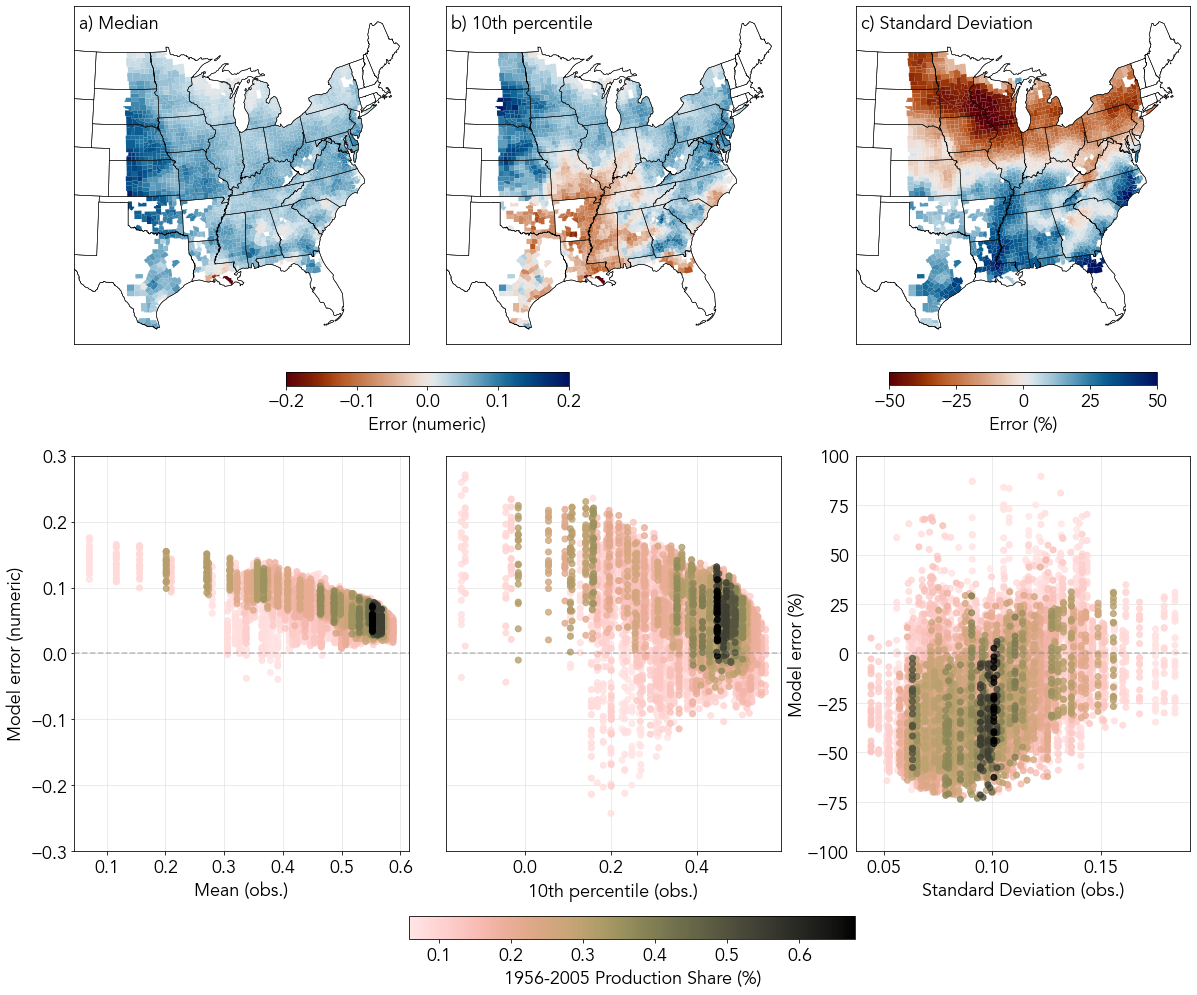

In [135]:
gridspec = dict(wspace = 0.15, hspace=0.005, width_ratios=[1, 1, 0., 1])
fig, axs = plt.subplots(2,4, figsize=(20,20), gridspec_kw=gridspec)
axs = axs.flatten()

axs[2].set_visible(False)
axs[6].set_visible(False)

############################
## Top row
############################

vmin = -0.2
vmax = 0.2
cmap = vik_map

# Mean
ax=axs[0]
stat = 'med'

plotdat = nex_weather_se_med - gmfd_weather_med
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' a) Median', loc = 'left', pad = -22, size=18)

# q10
ax=axs[1]
stat = 'q10'

plotdat = nex_weather_se_q10 - gmfd_weather_q10
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' b) 10th percentile', loc = 'left', pad = -22, size=18)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Error (numeric)', shrink=0.4, ax=axs[:2], pad=0.05)

# SD
vmin = -50.
vmax = 50.
cmap = vik_map

ax=axs[3]
stat = 'sd'

plotdat = (nex_weather_se_sd - gmfd_weather_sd) / np.abs(gmfd_weather_sd) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' c) Standard Deviation', loc = 'left', pad = -22, size=18)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Error (%)', shrink=0.8, ax=axs[3], pad=0.05, )

##############################
# Second row
##############################

# Choose how many counties
n = 500
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# 10th percentile
ax=axs[5]
ax.scatter(np.transpose([gmfd_weather_q10.loc[top_n].values] * 21),
           nex_weather_q10.loc[top_n].values - np.transpose([gmfd_weather_q10.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.set_ylim([-0.3,0.3])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('10th percentile (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)

# Mean
ax=axs[4]

ax.scatter(np.transpose([gmfd_weather_mean.loc[top_n].values] * 21),
           nex_weather_mean.loc[top_n].values - np.transpose([gmfd_weather_mean.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.set_ylim([-0.3,0.3])
ax.grid(alpha=0.3, zorder=0)
ax.set_ylabel('Model error (numeric)')
ax.set_xlabel('Mean (obs.)')

# SD
ax=axs[7]
ax.scatter(np.transpose([gmfd_weather_sd.loc[top_n].values] * 21),
           100 * (nex_weather_sd.loc[top_n].values - np.transpose([gmfd_weather_sd.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_weather_sd.loc[top_n].values] * 21)),
           c = colors,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation (obs.)')
ax.tick_params(axis='y', which='both', left=False)
ax.set_ylim([-100,100])
ax.set_ylabel('Model error (%)', labelpad=-0.5)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs[4:], shrink=0.4, pad=0.12)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')

# plt.show()
plt.savefig('../../figs/new/yield_map_scatter.pdf')

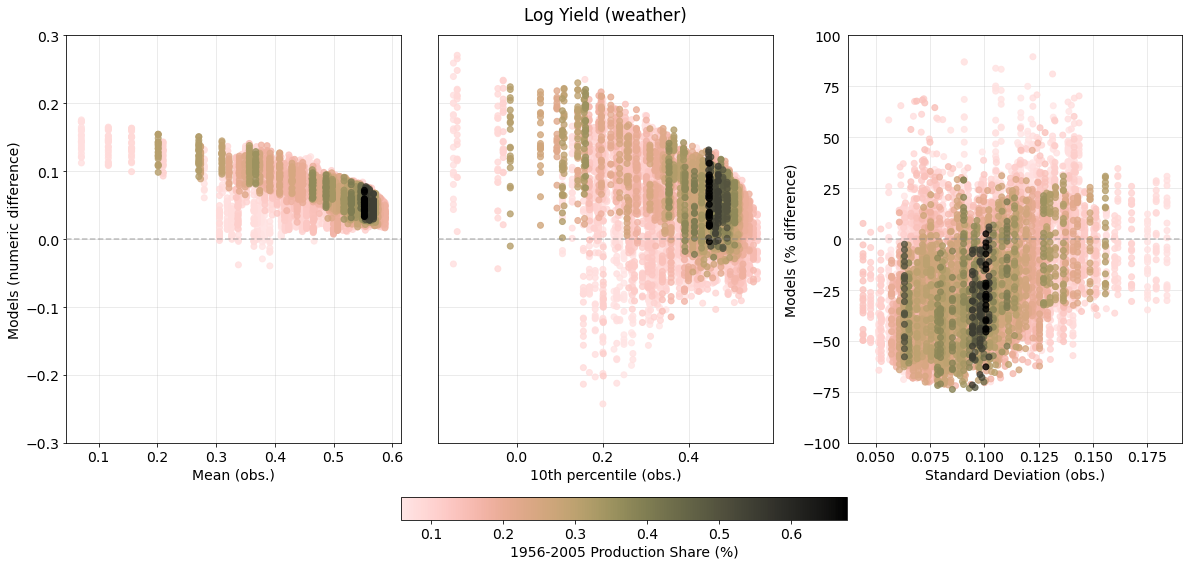

In [98]:
gridspec = dict(wspace = 0.15, width_ratios=[1, 1, 0., 1])
fig, axs = plt.subplots(1,4, figsize=(20,10), gridspec_kw=gridspec)
axs=axs.flatten()
axs[2].set_visible(False)

# Choose how many counties
n = 500
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# 10th percentile
ax=axs[1]
ax.scatter(np.transpose([gmfd_weather_q10.loc[top_n].values] * 21),
           nex_weather_q10.loc[top_n].values - np.transpose([gmfd_weather_q10.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.set_ylim([-0.3,0.3])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('10th percentile (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.set_title('Log Yield (weather)', pad = 15) # Figure title

# Mean
ax=axs[0]

ax.scatter(np.transpose([gmfd_weather_mean.loc[top_n].values] * 21),
           nex_weather_mean.loc[top_n].values - np.transpose([gmfd_weather_mean.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.set_ylim([-0.3,0.3])
ax.grid(alpha=0.3, zorder=0)
ax.set_ylabel('Models (numeric difference)')
ax.set_xlabel('Mean (obs.)')

# SD
ax=axs[3]
ax.scatter(np.transpose([gmfd_weather_sd.loc[top_n].values] * 21),
           100 * (nex_weather_sd.loc[top_n].values - np.transpose([gmfd_weather_sd.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_weather_sd.loc[top_n].values] * 21)),
           c = colors,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation (obs.)')
ax.tick_params(axis='y', which='both', left=False)
ax.set_ylim([-100,100])
ax.set_ylabel('Models (% difference)')

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs, shrink=0.4, pad=0.1)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')

plt.show()
# plt.savefig('../../figs/new/yield_scatter.pdf')

# EDD plots

In [61]:
# EDD metrics
nex_edd_q90 = nex_edd.groupby('fips').quantile(q=0.9)
gmfd_edd_q90 = gmfd.groupby('fips').quantile(q=0.9)['edd']

nex_edd_q10 = nex_edd.groupby('fips').quantile(q=0.1)
gmfd_edd_q10 = gmfd.groupby('fips').quantile(q=0.1)['edd']

nex_edd_med = nex_edd.groupby('fips').median()
gmfd_edd_med = gmfd.groupby('fips').median()['edd']

nex_edd_mean = nex_edd.groupby('fips').mean()
gmfd_edd_mean = gmfd.groupby('fips').mean()['edd']

nex_edd_sd = nex_edd.groupby('fips').std()
gmfd_edd_sd = gmfd.groupby('fips').std()['edd']

In [65]:
# Yield metrics (super-ensemble)

# Loop over each county
nex_edd_se = {}
for fips in all_fips:
    nex_edd_se.update({fips : nex_edd.loc[fips].to_numpy().flatten()})

# Dataframe
nex_edd_se = pd.DataFrame.from_dict(nex_edd_se, orient='index')
nex_edd_se.index.name = 'fips'

# Metrics
nex_edd_se_q90 = nex_edd_se.quantile(q=0.9, axis=1)
nex_edd_se_med = nex_edd_se.median(axis=1)
nex_edd_se_mean = nex_edd_se.mean(axis=1)
nex_edd_se_sd = nex_edd_se.std(axis=1)

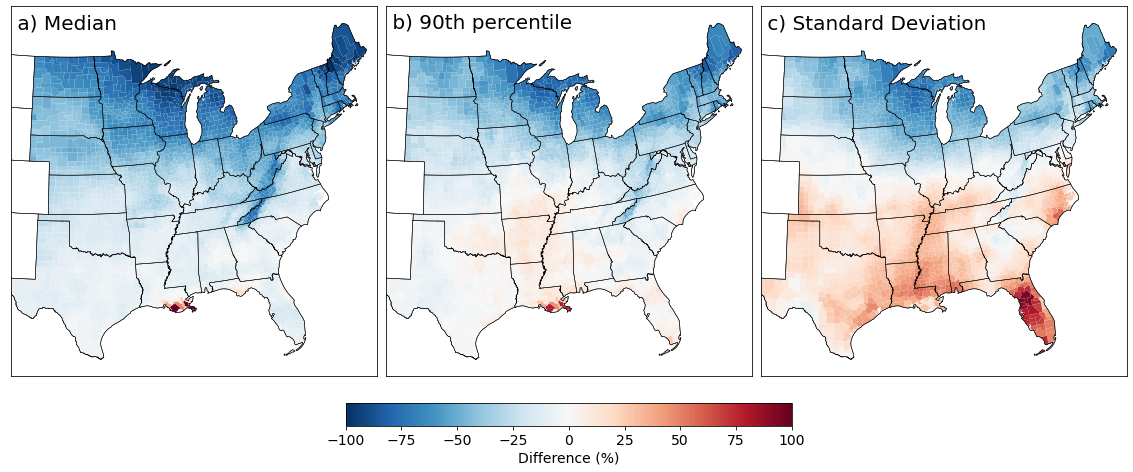

In [67]:
fig, axs = plt.subplots(1,3, figsize=(20,10), gridspec_kw={'wspace':0.025})
axs=axs.flatten()

vmin = -100.
vmax = 100.
cmap = 'RdBu_r'

# Median
ax=axs[0]
stat = 'median'

plotdat = (nex_edd_se_med - gmfd_edd_med) / np.abs(gmfd_edd_med) * 100
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' a) Median', loc = 'left', pad = -22, size=20)

# q90
ax=axs[1]
stat = 'q90'

plotdat = (nex_edd_se_q90 - gmfd_edd_q90) / np.abs(gmfd_edd_q90) * 100
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' b) 90th percentile', loc = 'left', pad = -22, size=20)

# SD
ax=axs[2]

plotdat = (nex_edd_se_sd - gmfd_edd_sd) / np.abs(gmfd_edd_sd) * 100
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' c) Standard Deviation', loc = 'left', pad = -22, size=20)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Difference (%)', shrink=0.4, ax=axs, pad=0.05)

plt.show()

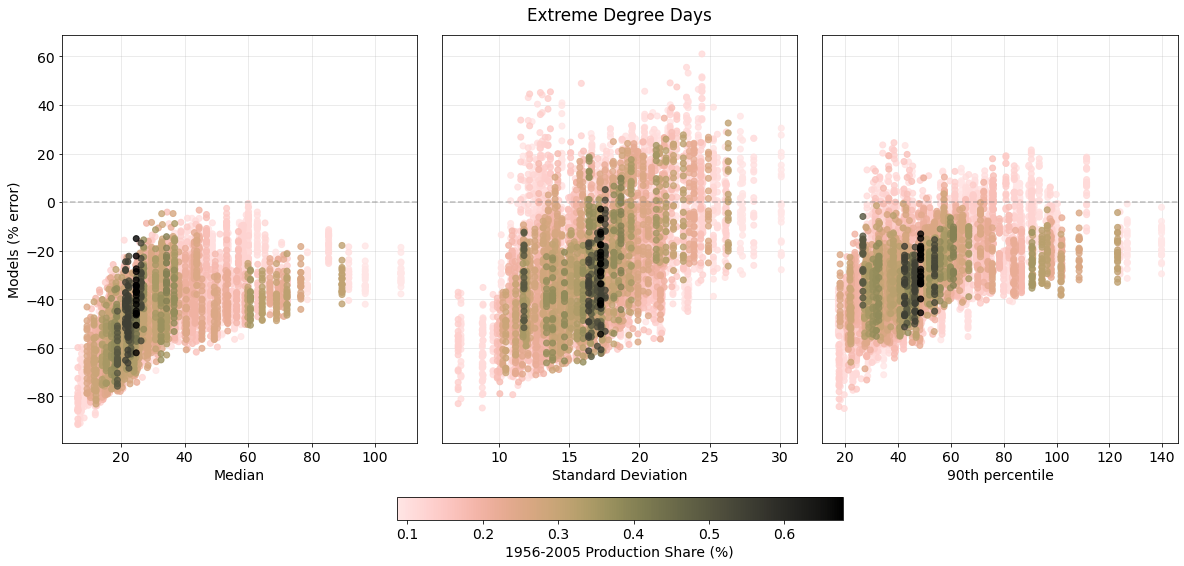

In [100]:
fig, axs = plt.subplots(1,3, figsize=(20,10), sharey=True, gridspec_kw={'wspace':0.07})
axs=axs.flatten()

# Choose how many counties
n = 400
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Median
ax=axs[0]
ax.scatter(np.transpose([gmfd_edd_med.loc[top_n].values] * 21),
           100 * (nex_edd_med.loc[top_n].values - np.transpose([gmfd_edd_med.loc[top_n].values] * 21)) / np.transpose([gmfd_edd_med.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_ylabel('Models (% error)')
ax.set_xlabel('Median')

# SD
ax=axs[1]
ax.scatter(np.transpose([gmfd_edd_sd.loc[top_n].values] * 21),
           100 * (nex_edd_sd.loc[top_n].values - np.transpose([gmfd_edd_sd.loc[top_n].values] * 21)) / np.transpose([gmfd_edd_sd.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8, zorder=10)


ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation')
ax.tick_params(axis='y', which='both', left=False)
ax.set_title('Extreme Degree Days', pad = 15) # Figure title

# 10th percentile
ax=axs[2]
ax.scatter(np.transpose([gmfd_edd_q90.loc[top_n].values] * 21),
           100 * (nex_edd_q90.loc[top_n].values - np.transpose([gmfd_edd_q90.loc[top_n].values] * 21)) / np.transpose([gmfd_edd_q90.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8,
           zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('90th percentile')
ax.tick_params(axis='y', which='both', left=False)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs, shrink=0.4, pad=0.1)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')
# plt.savefig('../../figs/new/EDD_scatter.pdf')
plt.show()

# GDD plots

In [353]:
# GDD metrics
nex_gdd_q10 = nex_gdd.groupby('fips').quantile(q=0.1)
gmfd_gdd_q10 = gmfd_clim.groupby('fips').quantile(q=0.1)['gdd']

nex_gdd_q90 = nex_gdd.groupby('fips').quantile(q=0.9)
gmfd_gdd_q90 = gmfd_clim.groupby('fips').quantile(q=0.9)['gdd']

nex_gdd_med = nex_gdd.groupby('fips').median()
gmfd_gdd_med = gmfd_clim.groupby('fips').median()['gdd']

nex_gdd_mean = nex_gdd.groupby('fips').mean()
gmfd_gdd_mean = gmfd_clim.groupby('fips').mean()['gdd']

nex_gdd_sd = nex_gdd.groupby('fips').std()
gmfd_gdd_sd = gmfd_clim.groupby('fips').std()['gdd']

In [354]:
# Yield metrics (super-ensemble)

# Loop over each county
nex_gdd_se = {}
for fips in gmfd_clim.index.get_level_values('fips').unique():
    nex_gdd_se.update({fips : nex_gdd.loc[fips].to_numpy().flatten()})

# Dataframe
nex_gdd_se = pd.DataFrame.from_dict(nex_gdd_se, orient='index')
nex_gdd_se.index.name = 'fips'

# Metrics
nex_gdd_se_q10 = nex_gdd_se.quantile(q=0.1, axis=1)
nex_gdd_se_med = nex_gdd_se.median(axis=1)
nex_gdd_se_mean = nex_gdd_se.mean(axis=1)
nex_gdd_se_sd = nex_gdd_se.std(axis=1)

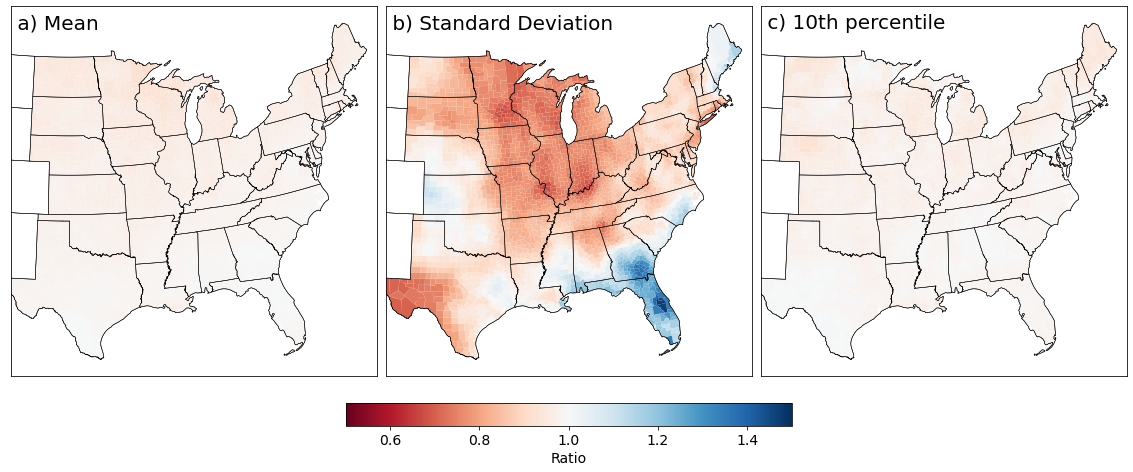

In [355]:
fig, axs = plt.subplots(1,3, figsize=(20,10), gridspec_kw={'wspace':0.025})
axs=axs.flatten()

# Median
ax=axs[0]
stat = 'mean'
vmin = 0.5
vmax = 1.5

plotdat = nex_gdd_se_mean / gmfd_gdd_mean
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap='RdBu')

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' a) Mean', loc = 'left', pad = -22, size=20)

# SD
ax=axs[1]
stat = 'sd'
vmin = 0.5
vmax = 1.5

plotdat = nex_gdd_se_sd / gmfd_gdd_sd
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap='RdBu')

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' b) Standard Deviation', loc = 'left', pad = -22, size=20)

# q10
ax=axs[2]
stat = 'q10'
vmin = 0.5
vmax = 1.5

plotdat = nex_gdd_se_q10 / gmfd_gdd_q10
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap='RdBu')

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' c) 10th percentile', loc = 'left', pad = -22, size=20)

# Colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Ratio', shrink=0.4, ax=axs, pad=0.05)

plt.show()

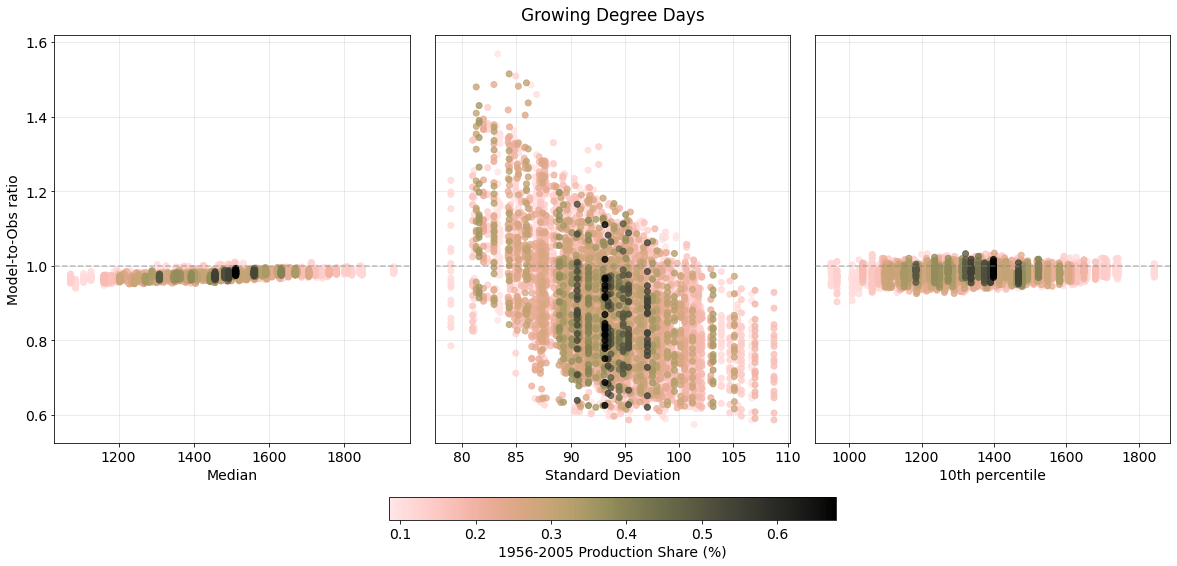

In [295]:
fig, axs = plt.subplots(1,3, figsize=(20,10), sharey=True, gridspec_kw={'wspace':0.07})
axs=axs.flatten()

# Choose how many counties
n = 400
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Median
ax=axs[0]
ax.scatter(np.transpose([gmfd_gdd_med.loc[top_n].values] * 21),
           nex_gdd_med.loc[top_n].values / np.transpose([gmfd_gdd_med.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(1, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_ylabel('Model-to-Obs ratio')
ax.set_xlabel('Median')

# SD
ax=axs[1]
ax.scatter(np.transpose([gmfd_gdd_sd.loc[top_n].values] * 21),
           nex_gdd_sd.loc[top_n].values / np.transpose([gmfd_gdd_sd.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8, zorder=10)


ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(1, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation')
ax.tick_params(axis='y', which='both', left=False)
ax.set_title('Growing Degree Days', pad = 15) # Figure title

# 10th percentile
ax=axs[2]
ax.scatter(np.transpose([gmfd_gdd_q10.loc[top_n].values] * 21),
           nex_gdd_q10.loc[top_n].values / np.transpose([gmfd_gdd_q10.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8,
           zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(1, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('10th percentile')
ax.tick_params(axis='y', which='both', left=False)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs, shrink=0.4, pad=0.1)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')
# plt.show()
plt.savefig('../../figs/new/GDD_scatter.pdf')

# Precip plots

In [367]:
# Precip metrics
nex_prcp_q10 = nex_prcp.groupby('fips').quantile(q=0.1)
gmfd_prcp_q10 = gmfd_clim.groupby('fips').quantile(q=0.1)['prcp']

nex_prcp_q90 = nex_prcp.groupby('fips').quantile(q=0.9)
gmfd_prcp_q90 = gmfd_clim.groupby('fips').quantile(q=0.9)['prcp']

nex_prcp_med = nex_prcp.groupby('fips').median()
gmfd_prcp_med = gmfd_clim.groupby('fips').median()['prcp']

nex_prcp_mean = nex_prcp.groupby('fips').mean()
gmfd_prcp_mean = gmfd_clim.groupby('fips').mean()['prcp']

nex_prcp_sd = nex_prcp.groupby('fips').std()
gmfd_prcp_sd = gmfd_clim.groupby('fips').std()['prcp']

In [365]:
# Yield metrics (super-ensemble)

# Loop over each county
nex_prcp_se = {}
for fips in gmfd_clim.index.get_level_values('fips').unique():
    nex_prcp_se.update({fips : nex_prcp.loc[fips].to_numpy().flatten()})

# Dataframe
nex_prcp_se = pd.DataFrame.from_dict(nex_prcp_se, orient='index')
nex_prcp_se.index.name = 'fips'

# Metrics
nex_prcp_se_q10 = nex_prcp_se.quantile(q=0.1, axis=1)
nex_prcp_se_med = nex_prcp_se.median(axis=1)
nex_prcp_se_mean = nex_prcp_se.mean(axis=1)
nex_prcp_se_sd = nex_prcp_se.std(axis=1)

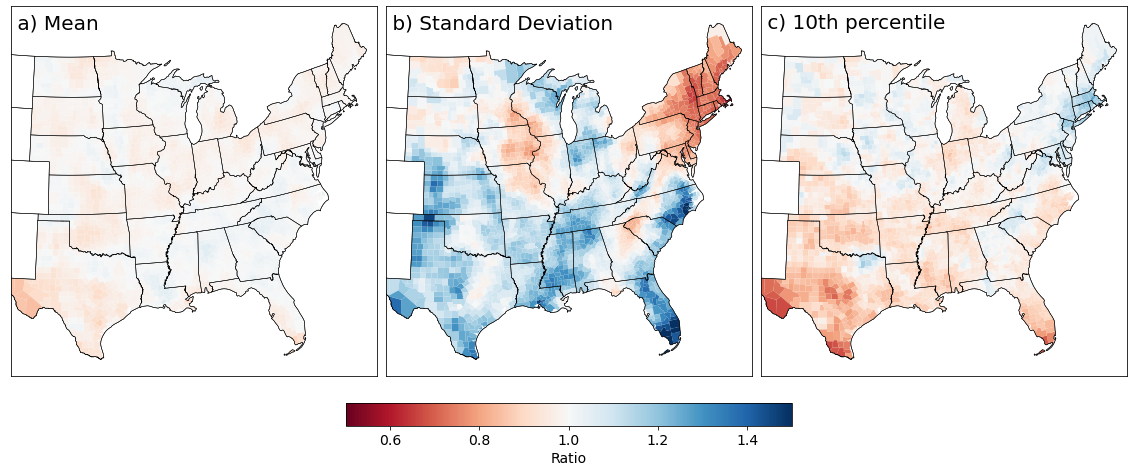

In [368]:
fig, axs = plt.subplots(1,3, figsize=(20,10), gridspec_kw={'wspace':0.025})
axs=axs.flatten()

# Median
ax=axs[0]
stat = 'mean'
vmin = 0.5
vmax = 1.5

plotdat = nex_prcp_se_mean / gmfd_prcp_mean
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap='RdBu')

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' a) Mean', loc = 'left', pad = -22, size=20)

# SD
ax=axs[1]
stat = 'sd'
vmin = 0.5
vmax = 1.5

plotdat = nex_prcp_se_sd / gmfd_prcp_sd
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap='RdBu')

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' b) Standard Deviation', loc = 'left', pad = -22, size=20)

# q10
ax=axs[2]
stat = 'q10'
vmin = 0.5
vmax = 1.5

plotdat = nex_prcp_se_q10 / gmfd_prcp_q10
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap='RdBu')

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' c) 10th percentile', loc = 'left', pad = -22, size=20)

# Colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Ratio', shrink=0.4, ax=axs, pad=0.05)

plt.show()

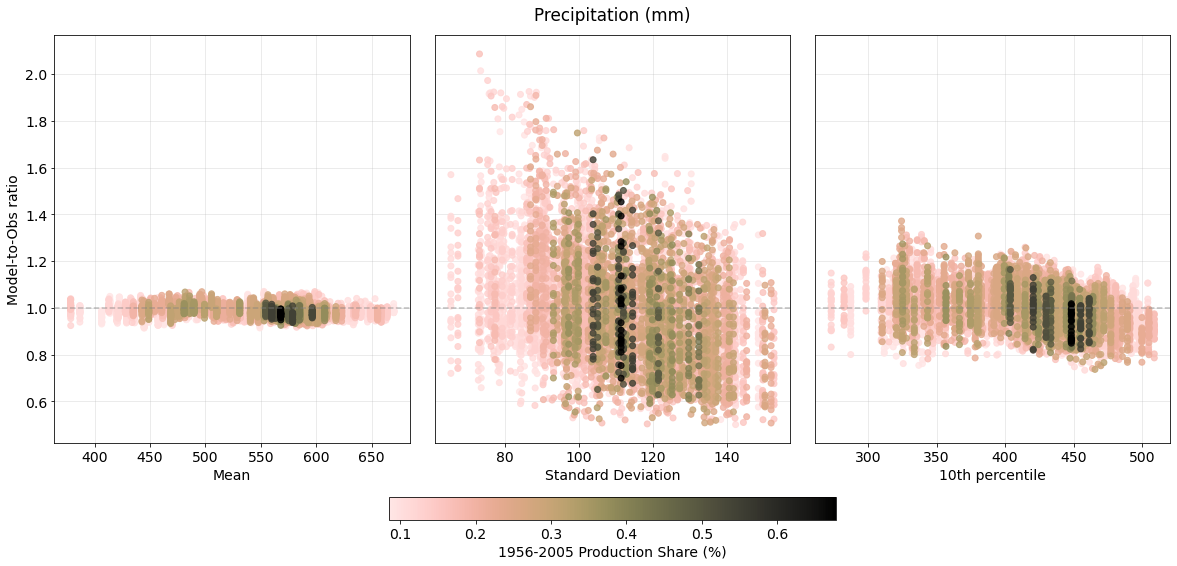

In [369]:
fig, axs = plt.subplots(1,3, figsize=(20,10), sharey=True, gridspec_kw={'wspace':0.07})
axs=axs.flatten()

# Choose how many counties
n = 400
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Median
ax=axs[0]
ax.scatter(np.transpose([gmfd_prcp_mean.loc[top_n].values] * 21),
           nex_prcp_mean.loc[top_n].values / np.transpose([gmfd_prcp_mean.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(1, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_ylabel('Model-to-Obs ratio')
ax.set_xlabel('Mean')

# SD
ax=axs[1]
ax.scatter(np.transpose([gmfd_prcp_sd.loc[top_n].values] * 21),
           nex_prcp_sd.loc[top_n].values / np.transpose([gmfd_prcp_sd.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8, zorder=10)


ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(1, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation')
ax.tick_params(axis='y', which='both', left=False)
ax.set_title('Precipitation (mm)', pad = 15) # Figure title

# 10th percentile
ax=axs[2]
ax.scatter(np.transpose([gmfd_prcp_q10.loc[top_n].values] * 21),
           nex_prcp_q10.loc[top_n].values / np.transpose([gmfd_prcp_q10.loc[top_n].values] * 21),
           c = colors,
           alpha=0.8,
           zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(1, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('10th percentile')
ax.tick_params(axis='y', which='both', left=False)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs, shrink=0.4, pad=0.1)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')
plt.show()
# plt.savefig('../../figs/new/precip_scatter.pdf')

In [14]:
# Read in CMIP models
cmip_models = !ls ../../data/yield/CMIP/hist
cmip = {model.replace("all_","").replace("_historical","").replace(".csv","") : pd.read_csv("../../data/yield/CMIP/hist/" + model) for model in cmip_models}
cmip_models = [model.replace("all_","").replace("_historical","").replace(".csv","") for model in cmip_models]

# CMIP yields
cmip_yield = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['yield'] for model in cmip_models}).dropna()
cmip_yield = cmip_yield.reset_index()
cmip_yield["fips"] = cmip_yield["fips"].astype(str).str.zfill(5)
cmip_yield.set_index(['fips','year'], inplace=True)

# CMIP EDD
cmip_edd = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['edd'] for model in cmip_models}).dropna()
cmip_edd = cmip_edd.reset_index()
cmip_edd["fips"] = cmip_edd["fips"].astype(str).str.zfill(5)
cmip_edd.set_index(['fips','year'], inplace=True)

# CMIP GDD
cmip_gdd = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['gdd'] for model in cmip_models}).dropna()
cmip_gdd = cmip_gdd.reset_index()
cmip_gdd["fips"] = cmip_gdd["fips"].astype(str).str.zfill(5)
cmip_gdd.set_index(['fips','year'], inplace=True)

### Old plots

In [ ]:
# OLD
# fig, axs = plt.subplots(1,3, figsize=(20,10))
# axs=axs.flatten()

# # Choose how many counties
# n = 500
# top_n = weights_all['national_weight'].sort_values()[-n:].index
# weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
# colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# # Median
# ax=axs[0]
# ax.scatter(np.transpose([gmfd_edd_med.loc[top_n].values] * 21),
#            nex_edd_med.loc[top_n].values,
#            c = colors,
#            alpha=0.8)

# ax.plot([np.min([ax.get_xlim(),ax.get_ylim()]),np.max([ax.get_xlim(),ax.get_ylim()])],
#         [np.min([ax.get_xlim(),ax.get_ylim()]),np.max([ax.get_xlim(),ax.get_ylim()])],
#         ls='--', color='grey')
# ax.text(0.03, 0.95, 'a) Median', transform=ax.transAxes)
# ax.set_ylabel('Models')
# ax.set_xlabel('Obs.')

# # SD
# ax=axs[1]
# ax.scatter(np.transpose([gmfd_edd_sd.loc[top_n].values] * 21),
#            nex_edd_sd.loc[top_n].values,
#            c = colors,
#            alpha=0.8)

# ax.plot([np.min([ax.get_xlim(),ax.get_ylim()]),np.max([ax.get_xlim(),ax.get_ylim()])],
#         [np.min([ax.get_xlim(),ax.get_ylim()]),np.max([ax.get_xlim(),ax.get_ylim()])],
#         ls='--', color='grey')
# ax.text(0.03, 0.95, 'b) Standard Deviation', transform=ax.transAxes)
# ax.set_xlabel('Obs.')

# ax.set_title('Extreme Degree Days', pad = 15) # Figure title

# # 10th percentile
# ax=axs[2]
# ax.scatter(np.transpose([gmfd_edd_q90.loc[top_n].values] * 21),
#            nex_edd_q90.loc[top_n].values,
#            c = colors,
#            alpha=0.8)

# ax.plot([np.min([ax.get_xlim(),ax.get_ylim()]),np.max([ax.get_xlim(),ax.get_ylim()])],
#         [np.min([ax.get_xlim(),ax.get_ylim()]),np.max([ax.get_xlim(),ax.get_ylim()])],
#         ls='--', color='grey')
# ax.text(0.03, 0.95, 'c) 90th Percentile', transform=ax.transAxes)
# ax.set_xlabel('Obs.')

# # Plot
# cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs, shrink=0.4, pad=0.1)
# cbar.ax.set_xlabel('1956-2005 Production Share (%)')

# plt.show()